In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method), PGD (Projected Gradient Descent) and UAP (Universal adversarial perturbations). To enhance your understanding, you will implement the PGD and UAP attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.



Good luck!

## outline

- Train Resnet on CIFAR10

- FGSM Attack using torchattacks

- PGD Attack from scratch

- UAP Attack from scratch

- Visualization

- Adversarial Training


Name: AmirHossein Haji Mohammad Rezaei



Student Number: 99109252

In [1]:
import torch

import torchvision

import torchvision.transforms as transforms

from torchvision.models import resnet18

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

import numpy as np

from torch.autograd import Variable

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

cuda:0


In [3]:
%%capture
! pip install gdown

In [4]:
! gdown 1MxHUo30vxLk7RETvF6Laxl7qo4uzXNz7
! gdown 1Lk2NBUAJ5RI6S-E0RZ0NuyeOz_GdbKus

Downloading...
From (original): https://drive.google.com/uc?id=1MxHUo30vxLk7RETvF6Laxl7qo4uzXNz7
From (redirected): https://drive.google.com/uc?id=1MxHUo30vxLk7RETvF6Laxl7qo4uzXNz7&confirm=t&uuid=e5c67781-ccd4-4ab4-aa8c-a57934f6a8a7
To: /kaggle/working/resnet18_cifar10_model_pretrained.pth
100%|██████████████████████████████████████| 44.8M/44.8M [00:00<00:00, 59.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Lk2NBUAJ5RI6S-E0RZ0NuyeOz_GdbKus
From (redirected): https://drive.google.com/uc?id=1Lk2NBUAJ5RI6S-E0RZ0NuyeOz_GdbKus&confirm=t&uuid=04fb53f5-e361-49c3-b34d-b9baa75a63bd
To: /kaggle/working/resnet18_cifar10_model_adv_trained.pth
100%|██████████████████████████████████████| 44.8M/44.8M [00:00<00:00, 72.0MB/s]


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Train Resnet on CIFAR10 (15 pts)

In [5]:
# Prepare Cifar10 data

batch_size = 128

train_transform = transforms.Compose([

    transforms.RandomCrop(32, padding=4),

    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),

])



test_transform = transforms.Compose([

    transforms.ToTensor(),

])



##############################################################################

# Prepare training and test datasets and dataloaders                         #

##############################################################################

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers=2)

################################ End #########################################



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 90797430.12it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# model architecture

class resnet(nn.Module):

  def __init__(self, num_cls):

    super().__init__()

    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])

    self.fc = nn.Linear(512, num_cls)



  def forward(self, x):

    x = self.conv(x)

    x = torch.flatten(x, start_dim=1)

    logits = self.fc(x)

    return logits



##############################################################################

# Initialize model and move to device                                        #

##############################################################################

model = resnet(10)

model = model.to(device)



################################ End #########################################

In [ ]:
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

epochs = 50

In [ ]:
##############################################################################

# Implement train loop and log training loss after each epoch                #

##############################################################################



def train(model, dataloader, criterion, optimizer, epoch):

  model.train()



  num_correct = 0

  total_loss = 0

  total = 0



  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:

    for i, (img, label) in pbar:

      img = img.to(device)

      label = label.to(device)



      optimizer.zero_grad()

      out = model(img)

      loss = criterion(out, label)

      loss.backward()

      optimizer.step()



      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()

      total_loss += loss.item()

      total += img.shape[0]



  acc = num_correct / total

  avg_loss = total_loss / total



  print(f'train: epoch {epoch}: acc: {acc}, avg loss: {avg_loss}')





for epoch in range(1, epochs + 1):

  train(model, trainloader, criterion, optimizer, epoch)

################################ End #########################################

100%|██████████| 391/391 [00:19<00:00, 20.09it/s]

train: epoch 1: acc: 0.39004, avg loss: 0.013097192764282227



100%|██████████| 391/391 [00:23<00:00, 16.47it/s]

train: epoch 2: acc: 0.51168, avg loss: 0.0105732585811615



100%|██████████| 391/391 [00:25<00:00, 15.12it/s]

train: epoch 3: acc: 0.58054, avg loss: 0.009217275425195693



100%|██████████| 391/391 [00:22<00:00, 17.46it/s]

train: epoch 4: acc: 0.62308, avg loss: 0.008381111637353897



100%|██████████| 391/391 [00:22<00:00, 17.37it/s]

train: epoch 5: acc: 0.65878, avg loss: 0.007596314824819565



100%|██████████| 391/391 [00:20<00:00, 18.83it/s]

train: epoch 6: acc: 0.68172, avg loss: 0.007096137274503708



100%|██████████| 391/391 [00:22<00:00, 17.54it/s]

train: epoch 7: acc: 0.69868, avg loss: 0.006692055608034134



100%|██████████| 391/391 [00:19<00:00, 19.81it/s]

train: epoch 8: acc: 0.7135, avg loss: 0.0063227084004879



100%|██████████| 391/391 [00:19<00:00, 19.87it/s]

train: epoch 9: acc: 0.73054, avg loss: 0.006034232228994369



100%|██████████| 391/391 [00:21<00:00, 18.52it/s]

train: epoch 10: acc: 0.7412, avg loss: 0.005758461245894432



100%|██████████| 391/391 [00:20<00:00, 18.65it/s]

train: epoch 11: acc: 0.7472, avg loss: 0.005609434719085694



100%|██████████| 391/391 [00:21<00:00, 18.25it/s]

train: epoch 12: acc: 0.75902, avg loss: 0.005350838454961777



100%|██████████| 391/391 [00:19<00:00, 20.02it/s]

train: epoch 13: acc: 0.76768, avg loss: 0.005187806292176246



100%|██████████| 391/391 [00:20<00:00, 19.51it/s]

train: epoch 14: acc: 0.77696, avg loss: 0.004995610237717629



100%|██████████| 391/391 [00:20<00:00, 19.38it/s]

train: epoch 15: acc: 0.78414, avg loss: 0.004822525497078896



100%|██████████| 391/391 [00:19<00:00, 20.41it/s]

train: epoch 16: acc: 0.78836, avg loss: 0.004693668930530548



100%|██████████| 391/391 [00:20<00:00, 19.19it/s]

train: epoch 17: acc: 0.7942, avg loss: 0.004565188035368919



100%|██████████| 391/391 [00:19<00:00, 20.37it/s]

train: epoch 18: acc: 0.80198, avg loss: 0.004454627704620361



100%|██████████| 391/391 [00:19<00:00, 20.49it/s]

train: epoch 19: acc: 0.80558, avg loss: 0.004276521943807602



100%|██████████| 391/391 [00:20<00:00, 19.07it/s]

train: epoch 20: acc: 0.81158, avg loss: 0.004208467884063721



100%|██████████| 391/391 [00:19<00:00, 20.44it/s]

train: epoch 21: acc: 0.8169, avg loss: 0.004049222275018692



100%|██████████| 391/391 [00:19<00:00, 19.71it/s]

train: epoch 22: acc: 0.82002, avg loss: 0.0039829204124212265



100%|██████████| 391/391 [00:21<00:00, 18.14it/s]

train: epoch 23: acc: 0.8251, avg loss: 0.0038766641372442244



100%|██████████| 391/391 [00:19<00:00, 20.09it/s]

train: epoch 24: acc: 0.82946, avg loss: 0.003802574478983879



100%|██████████| 391/391 [00:20<00:00, 19.48it/s]

train: epoch 25: acc: 0.83376, avg loss: 0.0036945787328481676



100%|██████████| 391/391 [00:19<00:00, 20.46it/s]

train: epoch 26: acc: 0.83744, avg loss: 0.00360153515458107



100%|██████████| 391/391 [00:20<00:00, 19.06it/s]

train: epoch 27: acc: 0.84058, avg loss: 0.0035123960727453233



100%|██████████| 391/391 [00:19<00:00, 20.49it/s]

train: epoch 28: acc: 0.84566, avg loss: 0.003422995916008949



100%|██████████| 391/391 [00:19<00:00, 20.50it/s]

train: epoch 29: acc: 0.84628, avg loss: 0.00336723935097456



100%|██████████| 391/391 [00:20<00:00, 19.29it/s]

train: epoch 30: acc: 0.85184, avg loss: 0.0033000553640723227



100%|██████████| 391/391 [00:19<00:00, 20.43it/s]

train: epoch 31: acc: 0.8529, avg loss: 0.0032449266040325167



100%|██████████| 391/391 [00:20<00:00, 19.44it/s]

train: epoch 32: acc: 0.85742, avg loss: 0.003165033703446388



100%|██████████| 391/391 [00:19<00:00, 20.25it/s]

train: epoch 33: acc: 0.86044, avg loss: 0.0030647962161898614



100%|██████████| 391/391 [00:18<00:00, 20.62it/s]

train: epoch 34: acc: 0.86252, avg loss: 0.003038249246776104



100%|██████████| 391/391 [00:21<00:00, 17.91it/s]

train: epoch 35: acc: 0.86592, avg loss: 0.002962933846414089



100%|██████████| 391/391 [00:18<00:00, 20.61it/s]

train: epoch 36: acc: 0.8703, avg loss: 0.002867932147681713



100%|██████████| 391/391 [00:20<00:00, 19.20it/s]

train: epoch 37: acc: 0.87102, avg loss: 0.0028066121119260786



100%|██████████| 391/391 [00:19<00:00, 20.56it/s]

train: epoch 38: acc: 0.87346, avg loss: 0.0027488498598337175



100%|██████████| 391/391 [00:19<00:00, 20.56it/s]

train: epoch 39: acc: 0.87804, avg loss: 0.002701359825730324



100%|██████████| 391/391 [00:20<00:00, 19.19it/s]

train: epoch 40: acc: 0.8792, avg loss: 0.0026582517501711846



100%|██████████| 391/391 [00:18<00:00, 20.64it/s]


train: epoch 41: acc: 0.8829, avg loss: 0.002586333097219467


100%|██████████| 391/391 [00:19<00:00, 19.83it/s]

train: epoch 42: acc: 0.88522, avg loss: 0.0025359632673859597



100%|██████████| 391/391 [00:19<00:00, 20.09it/s]

train: epoch 43: acc: 0.88654, avg loss: 0.00250106143951416



100%|██████████| 391/391 [00:18<00:00, 20.72it/s]

train: epoch 44: acc: 0.89164, avg loss: 0.0023737574073672296



100%|██████████| 391/391 [00:20<00:00, 19.31it/s]

train: epoch 45: acc: 0.89198, avg loss: 0.0023731420111656187



100%|██████████| 391/391 [00:18<00:00, 20.77it/s]

train: epoch 46: acc: 0.89456, avg loss: 0.002319363898336887



100%|██████████| 391/391 [00:20<00:00, 18.66it/s]

train: epoch 47: acc: 0.89436, avg loss: 0.0023102713972330095



100%|██████████| 391/391 [00:19<00:00, 19.78it/s]

train: epoch 48: acc: 0.8972, avg loss: 0.002254551303386688



100%|██████████| 391/391 [00:19<00:00, 20.44it/s]

train: epoch 49: acc: 0.9004, avg loss: 0.0021768567195534706



100%|██████████| 391/391 [00:20<00:00, 19.17it/s]

train: epoch 50: acc: 0.9016, avg loss: 0.0021418313321471213


In [ ]:
##############################################################################

# Evaluate the trained model on test set and print test accuracy             #

##############################################################################

def test(model, dataloader):

  model.eval()



  num_correct = 0

  total = 0



  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:

    for i, (img, label) in pbar:

      img = img.to(device)

      label = label.to(device)



      out = model(img)



      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()

      total += img.shape[0]



  acc = num_correct / total

  print(f'test accuracy: {acc}')









test(model, testloader)



################################ End #########################################

100%|██████████| 79/79 [00:02<00:00, 38.79it/s]

test accuracy: 0.8029


In [ ]:
# Save model

model.eval()

model_name = "/content/drive/MyDrive/resnet18_cifar10_model_pretrained.pth"

model_PATH = f"{model_name}"

torch.save(model.state_dict(), model_PATH)

In [8]:
model.load_state_dict(torch.load("/kaggle/working/resnet18_cifar10_model_pretrained.pth"))

model = model.eval()

/tmp/ipykernel_30/110467163.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet18_cifar10_model_pretrained.pth"))


In [9]:
def test(model, dataloader):

  model.eval()



  num_correct = 0

  total = 0



  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:

    for i, (img, label) in pbar:

      img = img.to(device)

      label = label.to(device)



      out = model(img)



      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()

      total += img.shape[0]



  acc = num_correct / total

  print(f'test accuracy: {acc}')



test(model, testloader)

100%|██████████| 79/79 [00:02<00:00, 33.28it/s]

test accuracy: 0.8029


## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).



Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [9]:
%%capture

! pip install torchattacks

In [10]:
##############################################################################

# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #

##############################################################################

import torchattacks

def FGSM_attack(model, dataloader, eps):
  model.eval()
    
  attack = torchattacks.FGSM(model, eps=eps)

  num_correct = 0
  total = 0

  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:
    for i, (img, label) in pbar:
      img = img.to(device)
      label = label.to(device)

      adv_images = attack(img, label)
        
      out = model(adv_images)

      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()
      total += img.shape[0]

  acc = num_correct / total
  print(f'accuracy of fgsm attack with epsilon={int(eps * 255)}/{255}: {acc}')







FGSM_attack(model, testloader, 1/255)

################################ End #########################################

100%|██████████| 79/79 [00:03<00:00, 20.87it/s]

accuracy of fgsm attack with epsilon=1/255: 0.5762


In [ ]:
##############################################################################

# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #

##############################################################################

FGSM_attack(model, testloader, 4/255)



################################ End #########################################

100%|██████████| 79/79 [00:02<00:00, 27.28it/s]

accuracy of fgsm attack with epsilon=4/255: 0.1681


In [ ]:
##############################################################################

# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #

##############################################################################

FGSM_attack(model, testloader, 8/255)



################################ End #########################################

100%|██████████| 79/79 [00:03<00:00, 20.67it/s]

accuracy of fgsm attack with epsilon=8/255: 0.0539


## PGD Attack from scratch (15 pts)

In this section you should implement PGD attack from scratch.

In [13]:
class LinfPGDAttack(object):



    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):

        self.model = model

        self.epsilon = epsilon

        self.steps = k

        self.alpha = alpha



    def __call__(self, image, label):



        image = image.to(device)

        label = label.to(device)



        out = self.model(image)

        _, pred = torch.max(out, 1)



        perturbed_image = image.clone()

        perturbed_image.to(device)



        #if pred.item() == label.item():
        ##############################################################################
        # Implement a k step PGD attack of size alpha                                #
        # while always staying within epsilon distance from the initial point        #
        # Use cross entropy loss                                                     #
        ##############################################################################
        criterion = nn.CrossEntropyLoss()

        for _ in range(self.steps):
          perturbed_image.requires_grad = True
          outputs = model(perturbed_image)

          model.zero_grad()
          loss = criterion(outputs, label).to(device)
          loss.backward()

          adv_images = perturbed_image + self.alpha*perturbed_image.grad.sign()
          eta = torch.clamp(adv_images - image, min=-self.epsilon, max=self.epsilon)
          perturbed_image = torch.clamp(image + eta, min=0, max=1).detach_()
            ################################ End #########################################

        return perturbed_image

In [14]:
##############################################################################

# Evaluate PGD attack on the trained model with k=2,4,8                      #

##############################################################################



k_list = [2,4,8]



##############################################################################



def PGD_attack(model, dataloader, steps):

  model.eval()

  attack = LinfPGDAttack(model, k=steps)



  num_correct = 0

  total = 0



  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:

    for i, (img, label) in pbar:

      img = img.to(device)

      label = label.to(device)

      adv_images = attack(img, label)



      out = model(adv_images)



      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()

      total += img.shape[0]



  acc = num_correct / total

  print(f'\n accuracy of pgd attack with steps {steps}: {acc}')





for step in k_list:

  PGD_attack(model, testloader, step)

################################ End #########################################

100%|██████████| 79/79 [00:05<00:00, 13.61it/s]


 accuracy of pgd attack with steps 2: 0.1121



100%|██████████| 79/79 [00:09<00:00,  8.26it/s]


 accuracy of pgd attack with steps 4: 0.0131



100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


 accuracy of pgd attack with steps 8: 0.0033


## UAP Attack from scratch (15 pts)

In this section you should implement UAP attack from scratch.

In [21]:
import torchattacks



class UAPAttack(object):



    def __init__(self, model, epsilon=8/255, delta=2/255, max_iters=10, data_loader=None):

        self.model = model

        self.epsilon = epsilon

        self.delta = delta

        self.max_iters = max_iters

        self.data_loader = data_loader



        # Initialize universal perturbation to zero

        self.uap = torch.zeros(1, 3, 32, 32, device=device, requires_grad=True)





    def generate_uap(self):

        """

        Generate Universal Adversarial Perturbation (UAP) using the dataset.

        """

        for iter in range(self.max_iters):

            correct = 0

            total = 0



            for images, labels in self.data_loader:

                images, labels = images.to(device), labels.to(device)



                # Add the current universal perturbation to the images

                perturbed_images = torch.clamp(images + self.uap, 0, 1)



                # Perform forward pass with perturbed images

                outputs = self.model(perturbed_images)

                _, preds = torch.max(outputs, 1)



                ##############################################################################

                # Implement misclassification logic                                          #

                # Find misclassified images and calculate the gradient                       #

                # Update the universal perturbation using the calculated gradient            #

                ##############################################################################

                total += labels.size(0)

                correct += (preds != labels).sum().item()





                loss = nn.CrossEntropyLoss()(outputs, labels)

                loss.backward()



                self.uap.data += self.uap.grad.sign() * self.epsilon



                ################################ End #########################################



                # Project the universal perturbation to the epsilon ball

                ##############################################################################

                # Implement projection logic to keep UAP within epsilon bounds               #

                ##############################################################################

                self.uap.data = torch.clamp(self.uap.data, -self.epsilon, self.epsilon)

                self.uap.grad.zero_()



            success_rate = correct / total

            print(f"Iteration {iter}/{self.max_iters} - Success Rate: {success_rate * 100:.2f}%")



            if success_rate >= 1 - self.delta:

                print("Target misclassification rate achieved.")

                break



                ################################ End #########################################



        return self.uap



    def __call__(self, image):

        """

        Apply the universal perturbation to a given image.

        """

        image = image.to(device)

        perturbed_image = torch.clamp(image + self.uap, 0, 1)

        return perturbed_image

In [22]:
##############################################################################

# Evaluate UAP attack on the trained model with max_iters = 10               #

##############################################################################



max_iters = 10



##############################################################################



attack = UAPAttack(model, max_iters=max_iters, data_loader=testloader)

attack.generate_uap()



def UAP_attack(model, dataloader, attack):

  model.eval()



  num_correct = 0

  total = 0



  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:

    for i, (img, label) in pbar:

      img = img.to(device)

      label = label.to(device)

      adv_images = attack(img)



      out = model(adv_images)



      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()

      total += img.shape[0]



  acc = num_correct / total

  print(f'\n accuracy of UAP attack with max iters=10: {acc}')



UAP_attack(model, testloader, attack)

################################ End #########################################

Iteration 0/10 - Success Rate: 44.84%
Iteration 1/10 - Success Rate: 47.61%
Iteration 2/10 - Success Rate: 47.69%
Iteration 3/10 - Success Rate: 48.13%
Iteration 4/10 - Success Rate: 48.38%
Iteration 5/10 - Success Rate: 48.35%
Iteration 6/10 - Success Rate: 48.44%
Iteration 7/10 - Success Rate: 48.18%
Iteration 8/10 - Success Rate: 48.12%
Iteration 9/10 - Success Rate: 48.18%


100%|██████████| 79/79 [00:01<00:00, 69.38it/s]


 accuracy of UAP attack with max iters=10: 0.5795


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [58]:
##############################################################################

# Implement the function described                                           #

##############################################################################

def attack_visualize(model, dataloader, attack, attack_type = None, num_samples = 3):

  x = next(iter(dataloader))[:num_samples]

  imgs, labels = x

  imgs = imgs.to(device)

  labels = labels.to(device)



  if attack_type != 'UAP':

    adv_imgs = attack(imgs, labels)

  else:

    adv_imgs = attack(imgs)



  out = model(adv_imgs)

  _, preds = torch.max(out, dim=1)



  fig = plt.figure(figsize = (3 * 2, num_samples * 2))

  for i in range(num_samples):

    fig.add_subplot(num_samples, 2, 2*i + 1)

    plt.imshow(imgs[i].cpu().detach().permute(1, 2, 0).numpy())

    plt.title(f'truth label: {classes[labels[i]]}')

    plt.axis('off')



    fig.add_subplot(num_samples, 2, 2*i + 2)

    plt.imshow(adv_imgs[i].cpu().detach().permute(1, 2, 0).numpy())

    plt.title(f'adv pred label: {classes[preds[i]]}')

    plt.axis('off')





################################ End #########################################

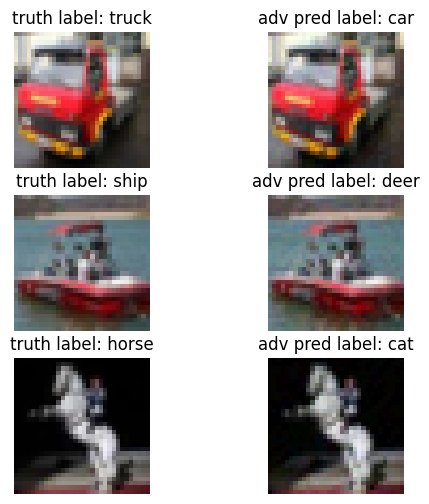

In [ ]:
##############################################################################

# Choose 3 random images from testset and run FGSM attack and visualize      #

##############################################################################



attack = torchattacks.FGSM(model, eps=4 / 255)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)

attack_visualize(model, testloader, attack, 'FGSM')











################################ End #########################################

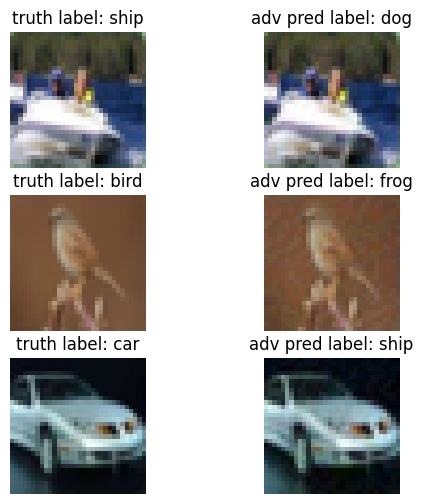

In [ ]:
##############################################################################

# Choose 3 random images from testset and run PGD attack and visualize      #

##############################################################################



LinfPGDAttack(model, k=4)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)

attack_visualize(model, testloader, attack, 'PGD')











################################ End #########################################

Iteration 0/10 - Success Rate: 45.39%
Iteration 1/10 - Success Rate: 47.71%
Iteration 2/10 - Success Rate: 47.72%
Iteration 3/10 - Success Rate: 47.64%
Iteration 4/10 - Success Rate: 47.51%
Iteration 5/10 - Success Rate: 47.82%
Iteration 6/10 - Success Rate: 47.67%
Iteration 7/10 - Success Rate: 47.45%
Iteration 8/10 - Success Rate: 48.08%
Iteration 9/10 - Success Rate: 48.01%


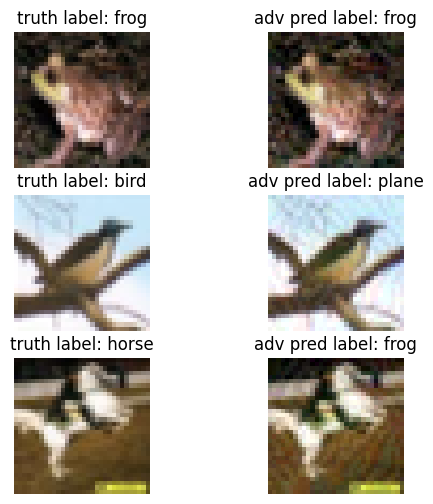

In [59]:
##############################################################################

# Choose 3 random images from testset and run UAP attack and visualize       #

##############################################################################



attack = UAPAttack(model, data_loader=testloader)

attack.generate_uap()

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)

attack_visualize(model, testloader, attack, 'UAP')







################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [66]:
##############################################################################

# Load a new resnet model for adversarial training                           #

# Train the model on perturbed images from                                   #

# untargeted FGSM attack with epsilon = 8/255 on train dataset               #

# Also use the following setup for training the model                        #

##############################################################################

import torchattacks



adv_model = resnet(10)

adv_model.to(device)



learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)

epochs = 50





def adv_train(model, attack, dataloader, criterion, optimizer, epoch):

  model.train()



  num_correct = 0

  total_loss = 0

  total = 0



  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:

    for i, (img, label) in pbar:

      img = img.to(device)

      label = label.to(device)



      adv_img = attack(img, label)



      optimizer.zero_grad()

      out = model(adv_img)

      loss = criterion(out, label)

      loss.backward()

      optimizer.step()



      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()

      total_loss += loss.item()

      total += img.shape[0]



  acc = num_correct / total

  avg_loss = total_loss / total



  print(f'adversarial train: epoch {epoch}: acc: {acc}, avg loss: {avg_loss}')





attack = torchattacks.FGSM(model, eps=8/255)

for epoch in range(1, epochs + 1):

  adv_train(adv_model, attack, trainloader, criterion, optimizer, epoch)



################################ End #########################################

100%|██████████| 391/391 [00:25<00:00, 15.16it/s]

adversarial train: epoch 1: acc: 0.37096, avg loss: 0.013601022942066193



100%|██████████| 391/391 [00:25<00:00, 15.10it/s]

adversarial train: epoch 2: acc: 0.46442, avg loss: 0.011497463569641113



100%|██████████| 391/391 [00:24<00:00, 16.12it/s]

adversarial train: epoch 3: acc: 0.50812, avg loss: 0.010606251938343048



100%|██████████| 391/391 [00:25<00:00, 15.26it/s]

adversarial train: epoch 4: acc: 0.53954, avg loss: 0.009966691021919251



100%|██████████| 391/391 [00:25<00:00, 15.47it/s]

adversarial train: epoch 5: acc: 0.5705, avg loss: 0.009399370826482773



100%|██████████| 391/391 [00:24<00:00, 16.02it/s]

adversarial train: epoch 6: acc: 0.59986, avg loss: 0.008841429373025895



100%|██████████| 391/391 [00:25<00:00, 15.32it/s]

adversarial train: epoch 7: acc: 0.62738, avg loss: 0.008293061654567719



100%|██████████| 391/391 [00:25<00:00, 15.58it/s]


adversarial train: epoch 8: acc: 0.6749, avg loss: 0.007378402514457703


100%|██████████| 391/391 [00:24<00:00, 15.95it/s]

adversarial train: epoch 9: acc: 0.70828, avg loss: 0.006627090961933136



100%|██████████| 391/391 [00:25<00:00, 15.24it/s]

adversarial train: epoch 10: acc: 0.73416, avg loss: 0.006182757705450058



100%|██████████| 391/391 [00:25<00:00, 15.59it/s]

adversarial train: epoch 11: acc: 0.75458, avg loss: 0.0057101759052276616



100%|██████████| 391/391 [00:24<00:00, 15.80it/s]

adversarial train: epoch 12: acc: 0.77334, avg loss: 0.005265385174751282



100%|██████████| 391/391 [00:25<00:00, 15.21it/s]

adversarial train: epoch 13: acc: 0.78642, avg loss: 0.004960324816703796



100%|██████████| 391/391 [00:25<00:00, 15.60it/s]

adversarial train: epoch 14: acc: 0.80488, avg loss: 0.00453009217262268



100%|██████████| 391/391 [00:24<00:00, 15.88it/s]

adversarial train: epoch 15: acc: 0.8128, avg loss: 0.004351980237960815



100%|██████████| 391/391 [00:25<00:00, 15.18it/s]

adversarial train: epoch 16: acc: 0.82552, avg loss: 0.00410799999833107



100%|██████████| 391/391 [00:24<00:00, 15.70it/s]

adversarial train: epoch 17: acc: 0.83088, avg loss: 0.0039144251722097395



100%|██████████| 391/391 [00:24<00:00, 15.64it/s]

adversarial train: epoch 18: acc: 0.8378, avg loss: 0.003742078865766525



100%|██████████| 391/391 [00:25<00:00, 15.13it/s]

adversarial train: epoch 19: acc: 0.8486, avg loss: 0.0035497983676195145



100%|██████████| 391/391 [00:24<00:00, 15.86it/s]

adversarial train: epoch 20: acc: 0.85406, avg loss: 0.0034012404215335848



100%|██████████| 391/391 [00:25<00:00, 15.48it/s]

adversarial train: epoch 21: acc: 0.85896, avg loss: 0.0032732867524027823



100%|██████████| 391/391 [00:25<00:00, 15.11it/s]

adversarial train: epoch 22: acc: 0.86188, avg loss: 0.003206048017144203



100%|██████████| 391/391 [00:24<00:00, 15.91it/s]

adversarial train: epoch 23: acc: 0.86898, avg loss: 0.0030472116795182227



100%|██████████| 391/391 [00:25<00:00, 15.37it/s]

adversarial train: epoch 24: acc: 0.87418, avg loss: 0.0029566078037023542



100%|██████████| 391/391 [00:25<00:00, 15.32it/s]

adversarial train: epoch 25: acc: 0.88012, avg loss: 0.0028459935620427134



100%|██████████| 391/391 [00:24<00:00, 15.99it/s]

adversarial train: epoch 26: acc: 0.8836, avg loss: 0.002732760863006115



100%|██████████| 391/391 [00:25<00:00, 15.26it/s]

adversarial train: epoch 27: acc: 0.88456, avg loss: 0.0027033272287249567



100%|██████████| 391/391 [00:25<00:00, 15.21it/s]

adversarial train: epoch 28: acc: 0.8894, avg loss: 0.0026154518631100656



100%|██████████| 391/391 [00:24<00:00, 15.97it/s]

adversarial train: epoch 29: acc: 0.89086, avg loss: 0.002525923925936222



100%|██████████| 391/391 [00:25<00:00, 15.32it/s]

adversarial train: epoch 30: acc: 0.89806, avg loss: 0.0024060358226299285



100%|██████████| 391/391 [00:25<00:00, 15.21it/s]

adversarial train: epoch 31: acc: 0.89754, avg loss: 0.002396409828066826



100%|██████████| 391/391 [00:24<00:00, 15.98it/s]

adversarial train: epoch 32: acc: 0.9001, avg loss: 0.002349844906926155



100%|██████████| 391/391 [00:25<00:00, 15.18it/s]

adversarial train: epoch 33: acc: 0.90226, avg loss: 0.0022792742627859115



100%|██████████| 391/391 [00:25<00:00, 15.34it/s]

adversarial train: epoch 34: acc: 0.90466, avg loss: 0.0022345773681998254



100%|██████████| 391/391 [00:24<00:00, 16.07it/s]

adversarial train: epoch 35: acc: 0.90536, avg loss: 0.0021895728546380997



100%|██████████| 391/391 [00:25<00:00, 15.31it/s]

adversarial train: epoch 36: acc: 0.90896, avg loss: 0.002115158261358738



100%|██████████| 391/391 [00:25<00:00, 15.45it/s]

adversarial train: epoch 37: acc: 0.91174, avg loss: 0.0020815489503741265



100%|██████████| 391/391 [00:24<00:00, 16.04it/s]

adversarial train: epoch 38: acc: 0.9128, avg loss: 0.0020189978738129138



100%|██████████| 391/391 [00:25<00:00, 15.25it/s]

adversarial train: epoch 39: acc: 0.91422, avg loss: 0.001998531935364008



100%|██████████| 391/391 [00:25<00:00, 15.64it/s]

adversarial train: epoch 40: acc: 0.91556, avg loss: 0.001974735810160637



100%|██████████| 391/391 [00:24<00:00, 16.09it/s]

adversarial train: epoch 41: acc: 0.91572, avg loss: 0.0019511348168551922



100%|██████████| 391/391 [00:25<00:00, 15.25it/s]

adversarial train: epoch 42: acc: 0.91878, avg loss: 0.0019061377950012684



100%|██████████| 391/391 [00:24<00:00, 15.67it/s]

adversarial train: epoch 43: acc: 0.92092, avg loss: 0.0018515477494895458



100%|██████████| 391/391 [00:24<00:00, 16.01it/s]

adversarial train: epoch 44: acc: 0.92246, avg loss: 0.001788509367853403



100%|██████████| 391/391 [00:25<00:00, 15.19it/s]

adversarial train: epoch 45: acc: 0.92476, avg loss: 0.0017567219984531402



100%|██████████| 391/391 [00:24<00:00, 15.76it/s]

adversarial train: epoch 46: acc: 0.92366, avg loss: 0.0017652043382823468



100%|██████████| 391/391 [00:25<00:00, 15.63it/s]

adversarial train: epoch 47: acc: 0.92472, avg loss: 0.001750935896486044



100%|██████████| 391/391 [00:25<00:00, 15.29it/s]

adversarial train: epoch 48: acc: 0.92546, avg loss: 0.0017102133445441722



100%|██████████| 391/391 [00:24<00:00, 15.81it/s]

adversarial train: epoch 49: acc: 0.93054, avg loss: 0.0016393706430494785



100%|██████████| 391/391 [00:25<00:00, 15.48it/s]

adversarial train: epoch 50: acc: 0.9298, avg loss: 0.0016272385343909263


In [67]:
# Save model

adv_model.eval()

model_name = "/content/drive/MyDrive/resnet18_cifar10_model_adv_trained.pth"

model_PATH = f"{model_name}"

torch.save(adv_model.state_dict(), model_PATH)

In [11]:
adv_model = resnet(10)
adv_model.load_state_dict(torch.load('/kaggle/working/resnet18_cifar10_model_adv_trained.pth'))
adv_model.eval()
adv_model = adv_model.to(device)

/tmp/ipykernel_30/2844530016.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_model.load_state_dict(torch.load('/kaggle/working/resnet18_cifar10_model_adv_trained.pth

In [15]:
##############################################################################

# Evaluate the new model on the test dataset                                 #

##############################################################################



test(adv_model, testloader)



################################ End #########################################

100%|██████████| 79/79 [00:01<00:00, 70.17it/s]

test accuracy: 0.5801


In [14]:
##############################################################################

# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #

##############################################################################
import torchattacks 

def FGSM_adv_attack(model, attack, dataloader, eps):
  model.eval()

  num_correct = 0
  total = 0

  with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:
    for i, (img, label) in pbar:
      img = img.to(device)
      label = label.to(device)

      adv_images = attack(img, label)
        
      out = model(adv_images)

      num_correct += torch.sum(torch.softmax(out, dim=1).argmax(dim=1) == label).item()
      total += img.shape[0]

  acc = num_correct / total
  print(f'accuracy of fgsm attack with epsilon={int(eps * 255)}/{255}: {acc}')

# FGSM adversarial sample created by original model

attack = torchattacks.FGSM(model, eps=8/255)
FGSM_adv_attack(adv_model, attack, testloader, 8/255)



################################ End #########################################

100%|██████████| 79/79 [00:02<00:00, 32.02it/s]

accuracy of fgsm attack with epsilon=8/255: 0.8798


In [15]:
# FGSM adversarial sample created by adversarial model
attack = torchattacks.FGSM(adv_model, eps=8/255)
FGSM_adv_attack(adv_model, attack, testloader, 8/255)

100%|██████████| 79/79 [00:02<00:00, 33.45it/s]

accuracy of fgsm attack with epsilon=8/255: 0.0002


In [73]:
##############################################################################

#  Run PGD attack on the adversarially trained model with k=4                #

##############################################################################



PGD_attack(adv_model, testloader, 4)



################################ End #########################################

100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


 accuracy of pgd attack with steps 4: 0.8582


In [24]:
##############################################################################

#  Run UAP attack on the adversarially trained model with max_iters = 10     #

##############################################################################



attack = UAPAttack(model, max_iters=max_iters, data_loader=testloader)

attack.generate_uap()

UAP_attack(adv_model, testloader, attack)



################################ End #########################################

Iteration 0/10 - Success Rate: 44.84%
Iteration 1/10 - Success Rate: 47.61%
Iteration 2/10 - Success Rate: 47.69%
Iteration 3/10 - Success Rate: 48.13%
Iteration 4/10 - Success Rate: 48.38%
Iteration 5/10 - Success Rate: 48.35%
Iteration 6/10 - Success Rate: 48.44%
Iteration 7/10 - Success Rate: 48.18%
Iteration 8/10 - Success Rate: 48.12%
Iteration 9/10 - Success Rate: 48.18%


100%|██████████| 79/79 [00:01<00:00, 67.62it/s]


 accuracy of UAP attack with max iters=10: 0.5293


In [25]:
attack = UAPAttack(adv_model, max_iters=max_iters, data_loader=testloader)

attack.generate_uap()

UAP_attack(adv_model, testloader, attack)

Iteration 0/10 - Success Rate: 89.28%
Iteration 1/10 - Success Rate: 89.97%
Iteration 2/10 - Success Rate: 89.96%
Iteration 3/10 - Success Rate: 89.97%
Iteration 4/10 - Success Rate: 89.96%
Iteration 5/10 - Success Rate: 89.97%
Iteration 6/10 - Success Rate: 89.96%
Iteration 7/10 - Success Rate: 89.98%
Iteration 8/10 - Success Rate: 89.96%
Iteration 9/10 - Success Rate: 89.96%


100%|██████████| 79/79 [00:01<00:00, 61.03it/s]


 accuracy of UAP attack with max iters=10: 0.1003


Answer the following questions:

- What happened to the accuracy of the adversarially trained model?

Answer: The aacuracy of adversarially trained model decreased on original test set compared to the model trained on the original training set.

- What do you conclude from the result of the FGSM attack on the adversarially trained model?

Answer: adversarially trained model is robust against adversarial examples created by the original model.

- What do you conclude from the result of the PGD attack on the adversarially trained model?

Answer: the adversarially trained model is also robust against adversarial examples of PGD attack.

- What do you conclude from the result of the UAP attack on the adversarially trained model?

Answer: test accuracy under UAP noise created by original model doesn't decrease a lot. However, the adversarially trained model isn't robust against UAP attack when UAP is created by adversarial trained model. Therefore, this results in that adversarially trained model isn't robust to UAP attack.

- What is you final conclusion?

Answer: adversarially trained model on adversarial examples created by FGSM is robust to FGSM and PGD attack except the UAP attack